## Import Dependencies

In [1]:
import os
import glob
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF

from tqdm.auto import tqdm

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Device Agnostic Code
device = "cuda" if torch.cuda.is_available() else "cpu"

## Data Preparation

In [3]:
# Open metadata
meta = pd.read_csv("/kaggle/input/skin-cancer-lesions-segmentation/data/metadata.csv")
meta.head()

,image,MEL,NV,BCC,AKIEC,BKL,DF,VASC
0,ISIC_0024306,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,ISIC_0024307,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,ISIC_0024308,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,ISIC_0024309,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,ISIC_0024310,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
meta["image"]

0        ISIC_0024306
1        ISIC_0024307
2        ISIC_0024308
3        ISIC_0024309
4        ISIC_0024310
             ...     
10010    ISIC_0034316
10011    ISIC_0034317
10012    ISIC_0034318
10013    ISIC_0034319
10014    ISIC_0034320
Name: image, Length: 10015, dtype: object

In [5]:
# Check for missing values
print(meta.isnull().sum(axis = 0))
print(meta.isna().sum(axis = 0)) # No missing values

image    0
MEL      0
NV       0
BCC      0
AKIEC    0
BKL      0
DF       0
VASC     0
dtype: int64
image    0
MEL      0
NV       0
BCC      0
AKIEC    0
BKL      0
DF       0
VASC     0
dtype: int64


In [6]:
# Create Partitions of Data
train_df, val_df = train_test_split(meta, train_size = 0.80, random_state = 42)
val_df, test_df = train_test_split(val_df, train_size = 0.50, random_state = 42)

In [7]:
len(train_df), len(val_df), len(test_df)

(8012, 1001, 1002)

In [8]:
# Images Mask Directory
IMAGES_DIR = "/kaggle/input/skin-cancer-lesions-segmentation/data/images/"
MASKS_DIR = "/kaggle/input/skin-cancer-lesions-segmentation/data/masks/"

In [9]:
# Create Dataset 
class SkinCancerDataset(Dataset):
    def __init__(self, images_dir, masks_dir, meta_data, transforms = None):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.meta_data = meta_data
        self.transforms = transforms
        
        
    def __len__(self):
        return len(self.meta_data)
    
    def __getitem__(self, idx):
        image_path = os.path.join(self.images_dir, self.meta_data.iloc[idx]["image"]+".jpg")
        mask_path = os.path.join(self.masks_dir, self.meta_data.iloc[idx]["image"]+".png")
        image = np.array(Image.open(image_path).convert("RGB"), dtype = np.float32)
        mask = np.array(Image.open(mask_path).convert("L"), dtype = np.float32)
        mask[mask == 255.0] = 1.0
    
        
        if self.transforms is not None:
            augmentations = self.transforms(image = image, mask = mask)
            image = augmentations["image"]
            mask = augmentations["mask"]
            
        return image, mask

In [10]:
train_transform = A.Compose([
    A.Resize(height = 256, width = 256),
    A.Normalize(mean = [0.0, 0.0, 0.0], std = [1.0, 1.0, 1.0], max_pixel_value = 255.0),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=45, p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    ToTensorV2()
])

val_transform = A.Compose([
    A.Resize(height = 256, width = 256),
    A.Normalize(mean = [0.0, 0.0, 0.0], std = [1.0, 1.0, 1.0], max_pixel_value = 255.0),
    ToTensorV2()
])

test_transform = A.Compose([
    A.Resize(height = 256, width = 256),
    A.Normalize(mean = [0.0, 0.0, 0.0], std = [1.0, 1.0, 1.0], max_pixel_value = 255.0),
    ToTensorV2()
])

In [11]:
train_dataset = SkinCancerDataset(IMAGES_DIR, MASKS_DIR, train_df, train_transform)
val_dataset = SkinCancerDataset(IMAGES_DIR, MASKS_DIR, val_df, val_transform)
test_dataset = SkinCancerDataset(IMAGES_DIR, MASKS_DIR, test_df, val_transform)

In [12]:
train_dataloader = DataLoader(train_dataset, batch_size = 32, shuffle = True)
val_dataloader = DataLoader(val_dataset, batch_size = 32, shuffle = False)
test_dataloader = DataLoader(test_dataset, batch_size = 32, shuffle = False)

In [13]:
data_iter = iter(train_dataloader)

## Initial Data Visualization

In [14]:
# Plot the first few images of a batch
example_batch = next(data_iter)

def plot_images(num_images:int):
    """
    Plot images and their corresponding masks from a batch
    (NOTE: num_images cannot be greater than the batch size)
    """
    fig = plt.figure(figsize = (15,10))
    num_rows = math.ceil(num_images / 2)
    num_cols = 4
    n = 0
    for i in range(num_images):
        img = example_batch[0][i]
        ax = plt.subplot(num_rows, num_cols, n+1)
        ax.imshow(torch.permute(img, [1,2,0]))
        ax.set_title(f"Image {i}")
        
        mask = example_batch[1][i]
        ax = plt.subplot(num_rows, num_cols, n+2)
        ax.imshow(mask, cmap = "gray")
        ax.set_title(f"Mask {i}")
        n+=2
    plt.tight_layout()
    plt.show()

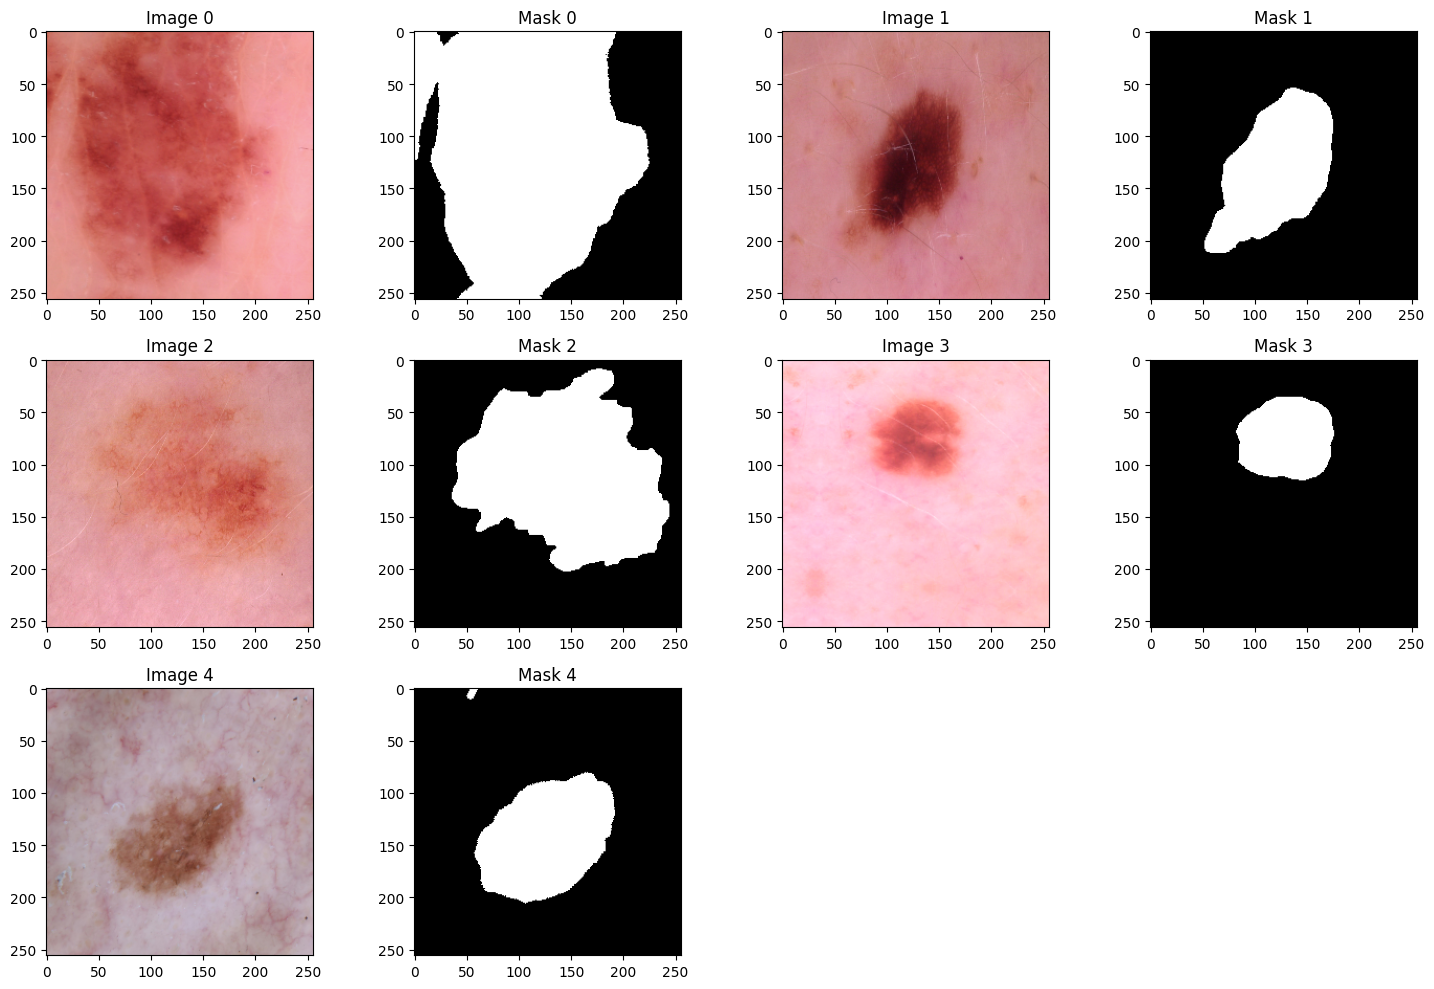

In [15]:
plot_images(5)

## Model Building

### U-Net Model

In [16]:
# Create a Double Convolutional Block
class DoubleConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv_block = nn.Sequential(nn.Conv2d(in_channels = in_channels,
                                                  out_channels = out_channels, 
                                                  kernel_size = 3, padding = 1, 
                                                  bias = False),
                                        nn.BatchNorm2d(out_channels),
                                        nn.ReLU(inplace = True),
                                        nn.Conv2d(in_channels = out_channels, 
                                                 out_channels = out_channels, 
                                                 kernel_size = 3, padding = 1, 
                                                  bias = False),
                                        nn.BatchNorm2d(out_channels),
                                        nn.ReLU(inplace = True))
    def forward(self, x):
        return self.conv_block(x)

In [17]:
class UNet(nn.Module):
    def __init__(self, in_channels = 3, out_channels = 1):
        super().__init__()
        self.inner_channels = [64,128,256,512]
        self.upsampling_layers = nn.ModuleList()
        self.downsampling_layers = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size = 2, stride = 2)
        
        # Create the Down Sampling Layers
        for channel in self.inner_channels:
            self.downsampling_layers.append(DoubleConvBlock(in_channels, channel))
            in_channels = channel
        
        # Create the Up Sampling Layers
        for channel in self.inner_channels[::-1]:
            self.upsampling_layers.append(nn.ConvTranspose2d(channel*2,
                                                            channel,
                                                            kernel_size = 2,
                                                            stride = 2))
            self.upsampling_layers.append(DoubleConvBlock(in_channels = channel*2, 
                                                          out_channels = channel))
        
        # Bottleneck Layer
        self.bottleneck_layer = DoubleConvBlock(in_channels = self.inner_channels[-1],
                                               out_channels = self.inner_channels[-1]*2)
        
        self.final_conv = nn.Conv2d(in_channels = self.inner_channels[0], 
                                    out_channels = 1, 
                                    kernel_size = 1)
        
    def forward(self, x):
        skip_connections = []

        for down in self.downsampling_layers:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck_layer(x)
        skip_connections = skip_connections[::-1]
        
        for i in range(0, len(self.upsampling_layers),2):
            x = self.upsampling_layers[i](x)
            skip_connection = skip_connections[i//2]

            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])
            
            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.upsampling_layers[i+1](concat_skip)

        return self.final_conv(x)
                    

In [18]:
# Initialize model and send to device
model = UNet().to(device)

### Optimizers and Loss Function

In [19]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCEWithLogitsLoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode = "min", 
                                                       factor = 0.1, patience = 3, 
                                                       verbose = True)
scaler = torch.cuda.amp.GradScaler()

### Creating the Training Loop

In [20]:
# Create basic training loop
# Overfit single batch
# for _ in range(10):
#     X, y = example_batch
#     X.to(device), y.to(device)
#     y_pred = model(X)
#     loss = criterion(y_pred, y)
#     print(loss.item())
#     optimizer.zero_grad()
#     loss.backward()
#     optimizer.step()

In [21]:
def pixel_accuracy(pred:torch.tensor, target:torch.tensor):
    """
    Calculate the pixel accuracy between prediction and target segmentation masks
    """
    predicted_probs = F.sigmoid(pred)
    pred_mask = torch.round(predicted_probs)
    
    num_correct = torch.eq(pred_mask, target).sum().item()
    total_pixels = target.numel()
    
    accuracy = num_correct / total_pixels
    return accuracy

In [22]:
# Early Stopping Callback
class EarlyStoppingCallback:
    def __init__(self, patience = 5, metric_name = "validation_loss"):
        self.patience = patience
        self.metric_name = metric_name
        self.best_metric_value = float("inf")
        self.counter = 0
    
    def __call__(self, current_metric_value):
        improvement = current_metric_value < self.best_metric_value
        
        if improvement:
            self.best_metric_value = current_metric_value
            self.counter = 0
        else:
            self.counter += 1
            
        return self.counter >= self.patience
        

In [23]:
# Model Checkpoint Callback
class ModelCheckpointCallback:
    def __init__(self, save_path = "best_runs", save_best_only=True, metric_name='validation_loss'):
        self.save_path = save_path
        self.save_best_only = save_best_only
        self.metric_name = metric_name
        self.best_metric_value = float('inf') 
        
        if not os.path.exists(save_path):
            os.makedirs(f"{save_path}")
            print(f"Creating Directory {save_path}")
        else:
            print("Directory already exists")

    def __call__(self, model, current_metric_value, epoch):
        if self.save_best_only:
            improvement = current_metric_value < self.best_metric_value
        else:
            improvement = True

        if improvement:
            self.best_metric_value = current_metric_value

            # Save the entire model state
            checkpoint_path = os.path.join(self.save_path, f'model_checkpoint_epoch_{epoch}.pth')
            torch.save(model.state_dict(), checkpoint_path)
            print(f'Model checkpoint saved at: {checkpoint_path}')

In [24]:
# Full training loop
def train_step(train_dataloader:DataLoader, val_dataloader:DataLoader, 
               model, optimizer, criterion, scaler, epochs = 100):
    """
    Trains the model on the train dataloader and validates with the val dataloader
    """
    train_losses = []
    val_losses = []
    pixel_accuracies = []
    val_pixel_accuracies = []
    
    early_stopping = EarlyStoppingCallback(patience=7, metric_name='validation_loss')
    model_checkpoint = ModelCheckpointCallback()
    for epoch in range(epochs):
        epoch_train_loss = 0
        epoch_pixel_accuracy = 0
        model.train()
        loop = tqdm(enumerate(train_dataloader), total = len(train_dataloader), leave = False)
        for batch, (X,y) in loop:
            # Load data into GPU
            X, y = X.to(device), y.to(device)
            y = torch.unsqueeze(y, dim = 1)

            with torch.cuda.amp.autocast():
                # Make prediction
                y_pred = model(X)
            
                # Calculate the loss
                train_loss = criterion(y_pred, y)
                epoch_train_loss += train_loss.item()
            
            # Calculate pixel accuracy
            batch_pixel_accuracy = pixel_accuracy(y_pred, y)
            epoch_pixel_accuracy += batch_pixel_accuracy
            
            # Zero gradients
            optimizer.zero_grad()
            
            # Backpropagation
            scaler.scale(train_loss).backward()
            
            # Gradient Descent
            scaler.step(optimizer)
            scaler.update()
            
            # Update Progress Bar
            loop.set_description(f"Epoch [{epoch+1}/{epochs}]")
            loop.set_postfix(loss = train_loss.item(), acc = batch_pixel_accuracy)
            
        # Append epoch train loss 
        epoch_train_loss = epoch_train_loss / len(train_dataloader)
        train_losses.append(epoch_train_loss)
        
        # Append epoch pixel accuracy
        epoch_pixel_accuracy = epoch_pixel_accuracy / len(train_dataloader)
        pixel_accuracies.append(epoch_pixel_accuracy)
        
        # Validation Step
        model.eval()
        epoch_val_loss = 0
        epoch_val_pixel_accuracy = 0
        with torch.inference_mode():
            val_loop = tqdm(enumerate(val_dataloader), total = len(val_dataloader), leave = False)
            for batch, (X,y) in val_loop:
                # Put data into GPU
                X, y = X.to(device), y.to(device)
                y = torch.unsqueeze(y, dim = 1)
                
                with torch.cuda.amp.autocast():
                    # Make prediction
                    y_pred = model(X)

                    # Caluclate the loss
                    val_loss = criterion(y_pred, y)
                    epoch_val_loss += val_loss.item()
                
                # Calculate pixel accuracy
                batch_pixel_accuracy = pixel_accuracy(y_pred, y)
                epoch_val_pixel_accuracy += batch_pixel_accuracy
                
                val_loop.set_description(f"Epoch [{epoch+1}/{epochs}]")
                val_loop.set_postfix(loss = val_loss.item(), acc = batch_pixel_accuracy)
            
            # Calculate average epoch loss
            epoch_val_loss /= len(val_dataloader)
            val_losses.append(epoch_val_loss)
            
            # Calculate average pixel accuracy
            epoch_val_pixel_accuracy = epoch_val_pixel_accuracy / len(val_dataloader)
            val_pixel_accuracies.append(epoch_val_pixel_accuracy)

        # Print outputs
        print(f"""Epoch: {epoch} | Train Loss: {epoch_train_loss} | Train Pixel Accuracy: {epoch_pixel_accuracy} | 
        Validation Loss: {epoch_val_loss} | Validation Pixel Accuracy: {epoch_val_pixel_accuracy}""")
        
        # Model Checkpoint Callback
        model_checkpoint(model, epoch_val_loss, epoch)
        
        # Early Stopping Callback
        if early_stopping(epoch_val_loss):
            print("Early Stopping")
            break
            
        scheduler.step(epoch_val_loss) # Reduce Learning Rate
        
    return {"Train Loss": train_losses, "Validation Loss" : val_losses, 
            "Train Pixel Accuracy" : pixel_accuracies, "Validation Pixel Accuracy" : val_pixel_accuracies}

In [25]:
history = train_step(train_dataloader, val_dataloader, model, optimizer, criterion, scaler)

Creating Directory best_runs


  0%|          | 0/251 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0 | Train Loss: 0.32177670769007555 | Train Pixel Accuracy: 0.8711039269587908 | 
        Validation Loss: 0.23135821102187037 | Validation Pixel Accuracy: 0.9081438283125559
Model checkpoint saved at: best_runs/model_checkpoint_epoch_0.pth


  0%|          | 0/251 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 1 | Train Loss: 0.24689810340148044 | Train Pixel Accuracy: 0.9044854099532048 | 
        Validation Loss: 0.22907278779894114 | Validation Pixel Accuracy: 0.9113952236043082
Model checkpoint saved at: best_runs/model_checkpoint_epoch_1.pth


  0%|          | 0/251 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 2 | Train Loss: 0.20697678391083305 | Train Pixel Accuracy: 0.9192139592620323 | 
        Validation Loss: 0.16839572391472757 | Validation Pixel Accuracy: 0.9348382403453191
Model checkpoint saved at: best_runs/model_checkpoint_epoch_2.pth


  0%|          | 0/251 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 3 | Train Loss: 0.19022318403203173 | Train Pixel Accuracy: 0.9264129522153898 | 
        Validation Loss: 0.16996042733080685 | Validation Pixel Accuracy: 0.931183194120725


  0%|          | 0/251 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 4 | Train Loss: 0.1749429975847799 | Train Pixel Accuracy: 0.9320312635515473 | 
        Validation Loss: 0.14881614386104047 | Validation Pixel Accuracy: 0.9406988587644365
Model checkpoint saved at: best_runs/model_checkpoint_epoch_4.pth


  0%|          | 0/251 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 5 | Train Loss: 0.16740473906001246 | Train Pixel Accuracy: 0.9348358164428873 | 
        Validation Loss: 0.12917574332095683 | Validation Pixel Accuracy: 0.9495549384090636
Model checkpoint saved at: best_runs/model_checkpoint_epoch_5.pth


  0%|          | 0/251 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 6 | Train Loss: 0.15871616233273805 | Train Pixel Accuracy: 0.9379869387602584 | 
        Validation Loss: 0.13029467384330928 | Validation Pixel Accuracy: 0.950115809837977


  0%|          | 0/251 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 7 | Train Loss: 0.1557719977015993 | Train Pixel Accuracy: 0.9395310356322513 | 
        Validation Loss: 0.1264582492876798 | Validation Pixel Accuracy: 0.9513137737909952
Model checkpoint saved at: best_runs/model_checkpoint_epoch_7.pth


  0%|          | 0/251 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 8 | Train Loss: 0.15313391147025554 | Train Pixel Accuracy: 0.9397146730308988 | 
        Validation Loss: 0.12979067163541913 | Validation Pixel Accuracy: 0.9483880284759734


  0%|          | 0/251 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 9 | Train Loss: 0.1484093355883165 | Train Pixel Accuracy: 0.9420804084534664 | 
        Validation Loss: 0.12520132842473686 | Validation Pixel Accuracy: 0.9508883853753408
Model checkpoint saved at: best_runs/model_checkpoint_epoch_9.pth


  0%|          | 0/251 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 10 | Train Loss: 0.14630163834983134 | Train Pixel Accuracy: 0.9424048685932539 | 
        Validation Loss: 0.1192781450226903 | Validation Pixel Accuracy: 0.9533191273609797
Model checkpoint saved at: best_runs/model_checkpoint_epoch_10.pth


  0%|          | 0/251 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 11 | Train Loss: 0.14549999627696567 | Train Pixel Accuracy: 0.9430280390330362 | 
        Validation Loss: 0.14091405947692692 | Validation Pixel Accuracy: 0.9457764791117774


  0%|          | 0/251 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 12 | Train Loss: 0.14146806017692345 | Train Pixel Accuracy: 0.9446812936192648 | 
        Validation Loss: 0.12494421214796603 | Validation Pixel Accuracy: 0.9512587918175591


  0%|          | 0/251 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 13 | Train Loss: 0.14044152304114574 | Train Pixel Accuracy: 0.9449947035486796 | 
        Validation Loss: 0.12867913814261556 | Validation Pixel Accuracy: 0.9490975621673796


  0%|          | 0/251 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 14 | Train Loss: 0.13660290733395344 | Train Pixel Accuracy: 0.9462280710379916 | 
        Validation Loss: 0.10876974510028958 | Validation Pixel Accuracy: 0.956766708029641
Model checkpoint saved at: best_runs/model_checkpoint_epoch_14.pth


  0%|          | 0/251 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 15 | Train Loss: 0.13733350874418282 | Train Pixel Accuracy: 0.9462388495841666 | 
        Validation Loss: 0.1261247037909925 | Validation Pixel Accuracy: 0.9488856924904717


  0%|          | 0/251 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 16 | Train Loss: 0.1349784928073446 | Train Pixel Accuracy: 0.9468455137326265 | 
        Validation Loss: 0.12052170909009874 | Validation Pixel Accuracy: 0.9535068455669615


  0%|          | 0/251 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 17 | Train Loss: 0.13507185716078102 | Train Pixel Accuracy: 0.9471547442128458 | 
        Validation Loss: 0.11087280826177448 | Validation Pixel Accuracy: 0.9566460053126017


  0%|          | 0/251 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 18 | Train Loss: 0.1312980509374246 | Train Pixel Accuracy: 0.948288942871499 | 
        Validation Loss: 0.11828288482502103 | Validation Pixel Accuracy: 0.953745875093672
Epoch 00019: reducing learning rate of group 0 to 1.0000e-04.


  0%|          | 0/251 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 19 | Train Loss: 0.12231878832398183 | Train Pixel Accuracy: 0.9518794734797787 | 
        Validation Loss: 0.1031749565154314 | Validation Pixel Accuracy: 0.9595459202925364
Model checkpoint saved at: best_runs/model_checkpoint_epoch_19.pth


  0%|          | 0/251 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 20 | Train Loss: 0.12125522506783208 | Train Pixel Accuracy: 0.9522362040333539 | 
        Validation Loss: 0.10134531557559967 | Validation Pixel Accuracy: 0.9598814762300916
Model checkpoint saved at: best_runs/model_checkpoint_epoch_20.pth


  0%|          | 0/251 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 21 | Train Loss: 0.12031601339697363 | Train Pixel Accuracy: 0.9524222566470365 | 
        Validation Loss: 0.1025171490618959 | Validation Pixel Accuracy: 0.9595708184772067


  0%|          | 0/251 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 22 | Train Loss: 0.12062094780612752 | Train Pixel Accuracy: 0.9528342414187245 | 
        Validation Loss: 0.10122063662856817 | Validation Pixel Accuracy: 0.9599312014049954
Model checkpoint saved at: best_runs/model_checkpoint_epoch_22.pth


  0%|          | 0/251 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 23 | Train Loss: 0.1179666447330756 | Train Pixel Accuracy: 0.9536327524172515 | 
        Validation Loss: 0.10025488142855465 | Validation Pixel Accuracy: 0.9605239232381185
Model checkpoint saved at: best_runs/model_checkpoint_epoch_23.pth


  0%|          | 0/251 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 24 | Train Loss: 0.11733009854695237 | Train Pixel Accuracy: 0.9540563636567013 | 
        Validation Loss: 0.10132451192475855 | Validation Pixel Accuracy: 0.960115792022811


  0%|          | 0/251 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 25 | Train Loss: 0.11679644643726102 | Train Pixel Accuracy: 0.9538791676758137 | 
        Validation Loss: 0.1010674845892936 | Validation Pixel Accuracy: 0.9600515100691054


  0%|          | 0/251 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 26 | Train Loss: 0.11765055120941177 | Train Pixel Accuracy: 0.9537150001779179 | 
        Validation Loss: 0.10050630336627364 | Validation Pixel Accuracy: 0.9602951357762018


  0%|          | 0/251 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 27 | Train Loss: 0.11740645472390718 | Train Pixel Accuracy: 0.9537872020625181 | 
        Validation Loss: 0.1004060524282977 | Validation Pixel Accuracy: 0.9604678120878007
Epoch 00028: reducing learning rate of group 0 to 1.0000e-05.


  0%|          | 0/251 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 28 | Train Loss: 0.11524520680842647 | Train Pixel Accuracy: 0.9546177213093832 | 
        Validation Loss: 0.09995580208487809 | Validation Pixel Accuracy: 0.9605213155349096
Model checkpoint saved at: best_runs/model_checkpoint_epoch_28.pth


  0%|          | 0/251 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 29 | Train Loss: 0.11466002517724892 | Train Pixel Accuracy: 0.9547885543954958 | 
        Validation Loss: 0.09919052687473595 | Validation Pixel Accuracy: 0.9607164065043131
Model checkpoint saved at: best_runs/model_checkpoint_epoch_29.pth


  0%|          | 0/251 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 30 | Train Loss: 0.11467152896274134 | Train Pixel Accuracy: 0.9547233277583027 | 
        Validation Loss: 0.09881965990643948 | Validation Pixel Accuracy: 0.9610010782877604
Model checkpoint saved at: best_runs/model_checkpoint_epoch_30.pth


  0%|          | 0/251 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 31 | Train Loss: 0.11492999742527407 | Train Pixel Accuracy: 0.9548169626182769 | 
        Validation Loss: 0.09896792168729007 | Validation Pixel Accuracy: 0.9609415299362607


  0%|          | 0/251 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 32 | Train Loss: 0.11414599552216283 | Train Pixel Accuracy: 0.9547856623433025 | 
        Validation Loss: 0.09976902836933732 | Validation Pixel Accuracy: 0.9607591794596778


  0%|          | 0/251 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 33 | Train Loss: 0.11374685540795326 | Train Pixel Accuracy: 0.9550197950872292 | 
        Validation Loss: 0.09917508042417467 | Validation Pixel Accuracy: 0.9608924173646503


  0%|          | 0/251 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 34 | Train Loss: 0.11460242880530566 | Train Pixel Accuracy: 0.9547558945330332 | 
        Validation Loss: 0.09935805865097791 | Validation Pixel Accuracy: 0.9608189894093407
Epoch 00035: reducing learning rate of group 0 to 1.0000e-06.


  0%|          | 0/251 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 35 | Train Loss: 0.11462831409625798 | Train Pixel Accuracy: 0.9548266545076611 | 
        Validation Loss: 0.09907764161471277 | Validation Pixel Accuracy: 0.9608466724554697


  0%|          | 0/251 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 36 | Train Loss: 0.11402485219843358 | Train Pixel Accuracy: 0.9551582019800842 | 
        Validation Loss: 0.0989426092710346 | Validation Pixel Accuracy: 0.9608705954419242


  0%|          | 0/251 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 37 | Train Loss: 0.11390818705952975 | Train Pixel Accuracy: 0.9551731618752043 | 
        Validation Loss: 0.09878615941852331 | Validation Pixel Accuracy: 0.9609626664055718
Model checkpoint saved at: best_runs/model_checkpoint_epoch_37.pth


  0%|          | 0/251 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 38 | Train Loss: 0.1149897404252533 | Train Pixel Accuracy: 0.9547251983784426 | 
        Validation Loss: 0.09936344902962446 | Validation Pixel Accuracy: 0.9607671813832389


  0%|          | 0/251 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 39 | Train Loss: 0.11424829598620119 | Train Pixel Accuracy: 0.9548451859320936 | 
        Validation Loss: 0.09905587858520448 | Validation Pixel Accuracy: 0.9609070850743188


  0%|          | 0/251 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 40 | Train Loss: 0.11409264783638406 | Train Pixel Accuracy: 0.9550841484728404 | 
        Validation Loss: 0.09902247821446508 | Validation Pixel Accuracy: 0.960858843392796


  0%|          | 0/251 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 41 | Train Loss: 0.11420288123932493 | Train Pixel Accuracy: 0.9549619432781165 | 
        Validation Loss: 0.09887688048183918 | Validation Pixel Accuracy: 0.9608900960948732
Epoch 00042: reducing learning rate of group 0 to 1.0000e-07.


  0%|          | 0/251 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 42 | Train Loss: 0.11411200287154472 | Train Pixel Accuracy: 0.9549275698414836 | 
        Validation Loss: 0.09897989686578512 | Validation Pixel Accuracy: 0.9609241551823087


  0%|          | 0/251 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 43 | Train Loss: 0.11460204694078738 | Train Pixel Accuracy: 0.9548385754366162 | 
        Validation Loss: 0.09871621138881892 | Validation Pixel Accuracy: 0.9609863956769308
Model checkpoint saved at: best_runs/model_checkpoint_epoch_43.pth


  0%|          | 0/251 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 44 | Train Loss: 0.11451765825133399 | Train Pixel Accuracy: 0.9550542217168517 | 
        Validation Loss: 0.09892838983796537 | Validation Pixel Accuracy: 0.9608902384837469


  0%|          | 0/251 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 45 | Train Loss: 0.11392641815531301 | Train Pixel Accuracy: 0.9551207009223036 | 
        Validation Loss: 0.0989692066796124 | Validation Pixel Accuracy: 0.9608498083220588


  0%|          | 0/251 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 46 | Train Loss: 0.11414029830658579 | Train Pixel Accuracy: 0.9550373715708456 | 
        Validation Loss: 0.09873401199001819 | Validation Pixel Accuracy: 0.960974825753106


  0%|          | 0/251 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 47 | Train Loss: 0.11392696664865273 | Train Pixel Accuracy: 0.9552845264652653 | 
        Validation Loss: 0.09896360465791076 | Validation Pixel Accuracy: 0.9609502620167203
Epoch 00048: reducing learning rate of group 0 to 1.0000e-08.


  0%|          | 0/251 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 48 | Train Loss: 0.11417982786656376 | Train Pixel Accuracy: 0.9551763445890915 | 
        Validation Loss: 0.09889864211436361 | Validation Pixel Accuracy: 0.9609154793951247


  0%|          | 0/251 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 49 | Train Loss: 0.11400124280754313 | Train Pixel Accuracy: 0.9551062989203262 | 
        Validation Loss: 0.0990979541093111 | Validation Pixel Accuracy: 0.9608263969421387


  0%|          | 0/251 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 50 | Train Loss: 0.1145788869000526 | Train Pixel Accuracy: 0.9550095586029499 | 
        Validation Loss: 0.09874969662632793 | Validation Pixel Accuracy: 0.9609591298633151
Early Stopping


## Evaluate Model Performance

In [27]:
# Load the model
model = UNet()
model.load_state_dict(torch.load("/kaggle/working/best_runs/model_checkpoint_epoch_43.pth"))

<All keys matched successfully>

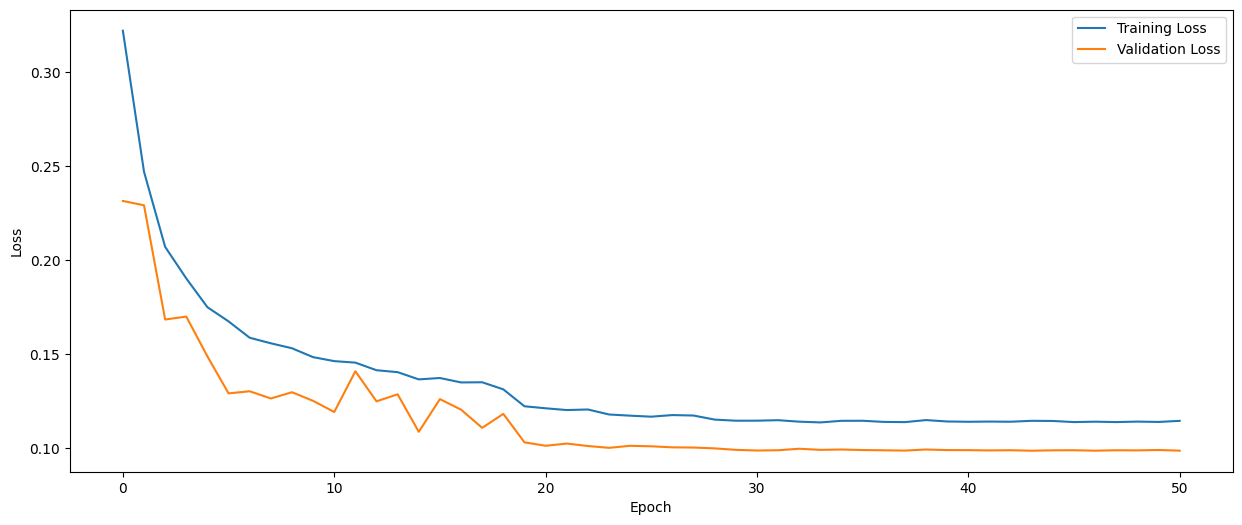

In [32]:
# Plot the loss values
plt.figure(figsize = (15,6))
plt.plot(history["Train Loss"], label = "Training Loss")
plt.plot(history["Validation Loss"], label = "Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

### Visualize on Images from Test Dataset

In [33]:
example_test_batch = next(iter(test_dataloader))
model.to(device)
model.eval()
with torch.inference_mode():
    X = example_test_batch[0].to(device)
    y = example_test_batch[1].to(device)
    y_pred = model(X)

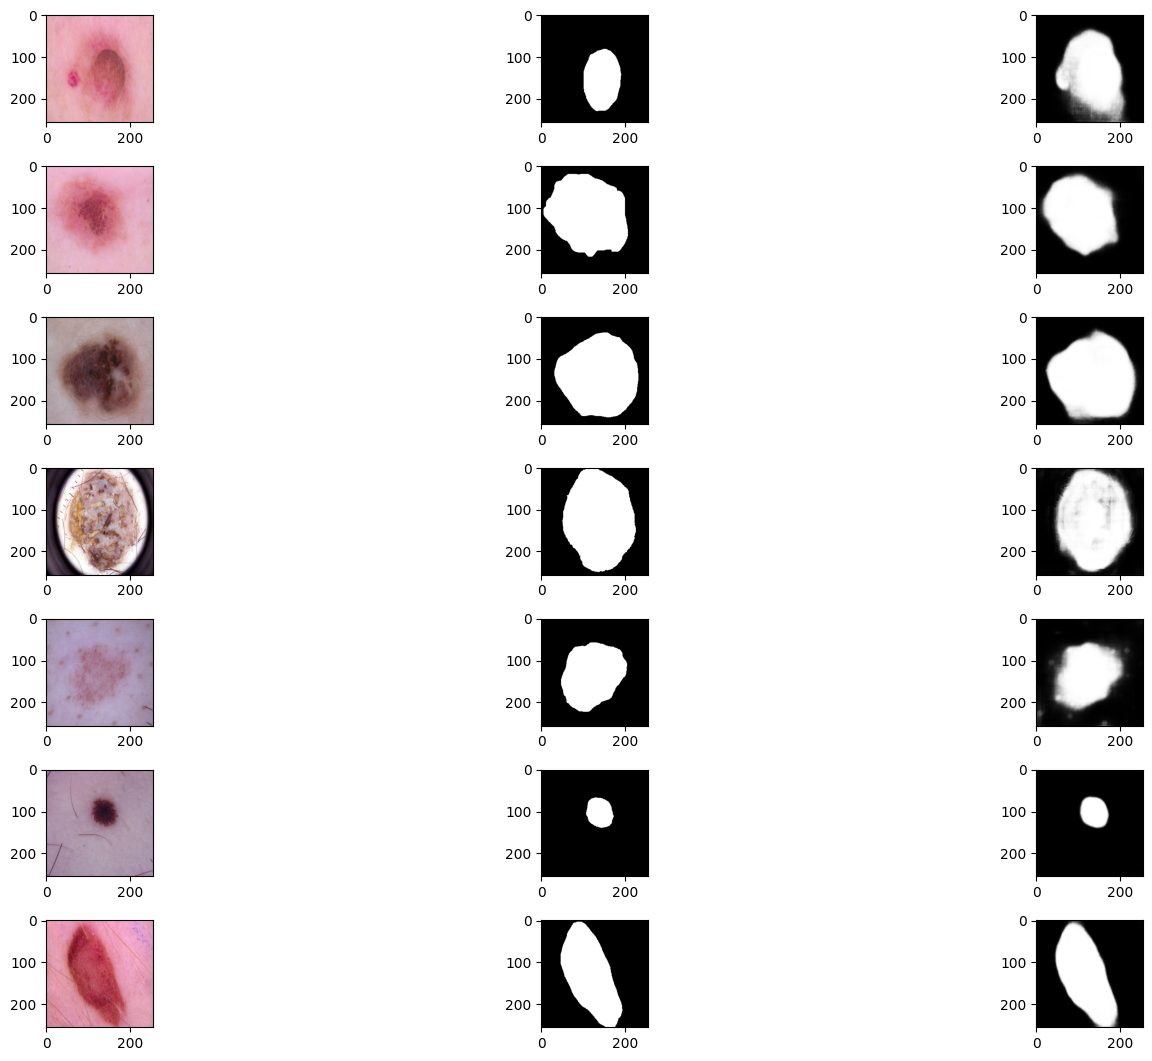

In [34]:
plt.figure(figsize = (15, 15))
for i in range(0,20,3):
    ax = plt.subplot(10,3,i+1)
    ax.imshow(torch.permute(example_test_batch[0][i], [1,2,0]))
    
    ax = plt.subplot(10, 3, i+2)
    ax.imshow(example_test_batch[1][i], cmap = "gray")
    
    ax = plt.subplot(10,3,i+3)
    ax.imshow(torch.permute(F.sigmoid(y_pred[i]).cpu(), [1, 2, 0]), cmap = "gray")
    
plt.tight_layout()
plt.show()